# Computer Vision Model

Here I will be building a computer vision model for multi class image classification. This model will be based off the TinyVGG architecture.

In [1]:
# Import libraries
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import pandas as pd

import torchmetrics
from torchmetrics import ConfusionMatrix

import mlxtend
from mlxtend.plotting import plot_confusion_matrix

from timeit import default_timer as timer
from tqdm.auto import tqdm
from pathlib import Path

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Retrieving a dataset (To test and train on)

The dataset I will be using in this experiment is the FashionMNIST set from `torchvision.datasets`

In [2]:
# Setup training data sets
train_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=True, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=torchvision.transforms.ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the labels/targets
)

# Setup testing data sets
test_data = datasets.FashionMNIST(
    root="data", # where to download data to
    train=False, # do we want the training dataset?
    download=True, # do we want to download yes/no?
    transform=ToTensor(), # how do we want to transform the data
    target_transform=None # how do we want to transform the labels/targets
)

In [3]:
len(train_data), len(test_data)

(60000, 10000)

In [4]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.1 See the input and output shapes of our data

In [6]:
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


### 1.2 Visualise the data to be able to better understand it 

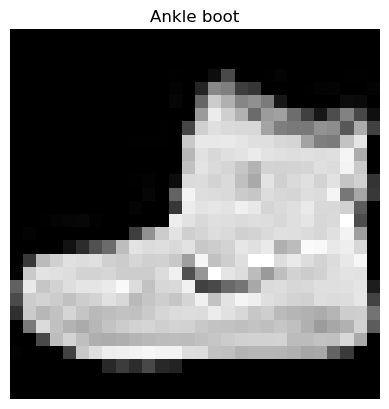

In [7]:
image, label = train_data[0]
# Print in greyscale
plt.imshow(image.squeeze(), cmap="gray") # Specify color
plt.title(class_names[label]) # Print label with image
plt.axis(False); # Do not show axis labels

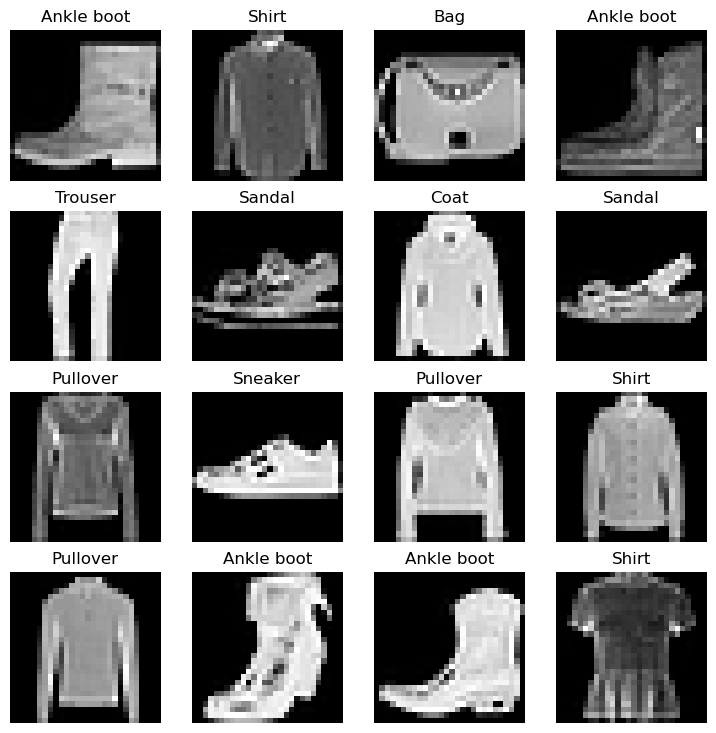

In [8]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 2. Prepare DataLoader

Turning our data into a Python iterable and splitting it in to batches to allow for better computation and to give our neural network more chances to update its gradients per epoch.

In [9]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x246e0d92d60>,
 <torch.utils.data.dataloader.DataLoader at 0x246e1207ac0>)

In [10]:
# See what we have created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataLoader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000246E0D92D60>, <torch.utils.data.dataloader.DataLoader object at 0x00000246E1207AC0>)
Length of train_dataLoader: 1875 batches of 32
Length of test_dataLoader: 313 batches of 32


In [11]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


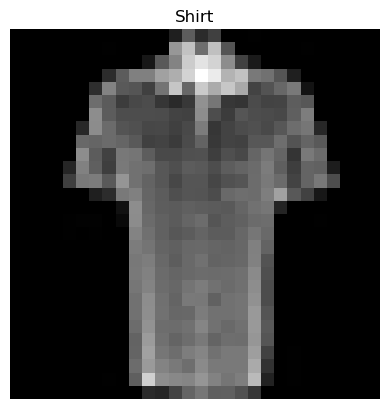

In [12]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image Size: {image.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Build the model (TinyVGG)

In [13]:
class TinyVGG(nn.Module):
    """
    Model architecture that replicates the TinyVGG model from CNN Explainer website.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1, 
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
        
    def forward(self, x):
        # pass through first layer
        x = self.conv_block_1(x)
        # pass through second layer
        x = self.conv_block_2(x)
        # pass through classifier
        x = self.classifier(x)
        return x

In [14]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=1, 
                  hidden_units=10, 
                  output_shape=len(class_names))
model_0.to(device)

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

### 3.1 Setting up loss, optimizer and accuracy functions

In [15]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer function
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

# Accuracy function
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.
    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.
    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 3.2 Set up training and testing loop

In [16]:
# Training loop
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    """
    Performs a training with model trying to learn on data_loader.
    """
    train_loss, train_acc = 0, 0
    ### Training
    model.train()
    
    # Add a loop to loop through the training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
        X, y = X.to(device), y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate loss then receive a average for the batch
        train_acc += accuracy_fn(y_true=y, 
                                 y_pred=y_pred.argmax(dim=1))
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        
        # 4. Loss backward
        loss.backward()
        
        # 5. Optimizer.step
        optimizer.step()
        
            
    #  Divide total train_loss and accuracy by length of train dataloader
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.5f} | Train_acc: {train_acc:.2f}%")

In [17]:
# Testing loop
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    """
    Performs a testing loop step on model going over data_loader
    """
    test_loss, test_acc = 0, 0
    # Put model in eval mode
    model.eval()
    
    # Turn on inference mode context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to target device
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate the loss/acc
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                                    y_pred=test_pred.argmax(dim=1))
            
        # Adjust metric and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

### 3.3 Run model through training and testing loops

In [18]:
%%time
torch.manual_seed(42)

# Set epochs
epochs = 7

# Create a optimization and evaluation loops using train_step() and test_step()
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    
    test_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               device=device)

  0%|          | 0/7 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59188 | Train_acc: 78.50%
Test loss: 0.36844 | Test accuracy: 86.79%

Epoch: 1
---------
Train loss: 0.36012 | Train_acc: 86.95%
Test loss: 0.38960 | Test accuracy: 86.61%

Epoch: 2
---------
Train loss: 0.32393 | Train_acc: 88.27%
Test loss: 0.30328 | Test accuracy: 89.00%

Epoch: 3
---------
Train loss: 0.30206 | Train_acc: 89.07%
Test loss: 0.28559 | Test accuracy: 89.55%

Epoch: 4
---------
Train loss: 0.28988 | Train_acc: 89.48%
Test loss: 0.28200 | Test accuracy: 89.79%

Epoch: 5
---------
Train loss: 0.28003 | Train_acc: 89.83%
Test loss: 0.26167 | Test accuracy: 90.56%

Epoch: 6
---------
Train loss: 0.27151 | Train_acc: 90.11%
Test loss: 0.26416 | Test accuracy: 90.47%

Wall time: 2min 46s


### 3.4 Get final results from model

In [19]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Set device agnostic code
            X, y = X.to(device), y.to(device)
            # Make predictions
            y_pred = model(X)
            
            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        # Scale the loss and accuracy to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [20]:
# Get model_0 results
model_0_results = eval_model(
    model=model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'TinyVGG',
 'model_loss': 0.30807551741600037,
 'model_acc': 89.34704472843451}

## 4. Make and evaluate random predictions with the model

In [21]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
    pred_probs = []
    model.eval()
    
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample (add a batch dimension and pass to target device)
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            # Forward pass (model outputs raw logits)
            pred_logit = model(sample)
            
            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            
            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
        # Stack the pred_probs to turn list into a tensor
        return torch.stack(pred_probs)

In [22]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
    test_samples.append(sample)
    test_labels.append(label)
    
# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

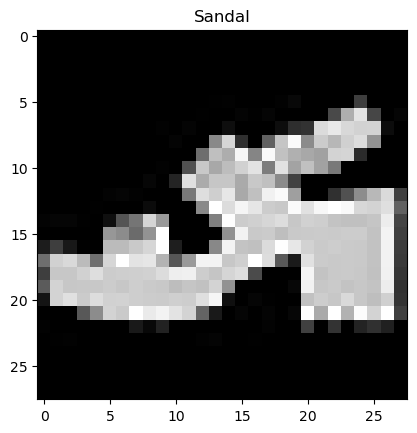

In [23]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]]);

In [25]:
# Make some predictions
pred_probs = make_predictions(model=model_0,
                              data=test_samples)

# View first two predictions
pred_probs[:2]

tensor([[9.3623e-10, 1.1816e-10, 8.8141e-10, 9.6543e-12, 6.2122e-10, 9.9994e-01,
         6.8503e-11, 7.7934e-08, 9.5558e-07, 6.0658e-05],
        [1.3020e-03, 9.9830e-01, 4.3288e-07, 1.4491e-04, 1.0431e-04, 5.0355e-08,
         1.3643e-04, 6.1701e-07, 1.0126e-05, 1.2352e-07]])

In [26]:
# Covert prediction probabilites to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 6, 4, 7, 1, 9, 7, 2, 0, 1, 0, 3])

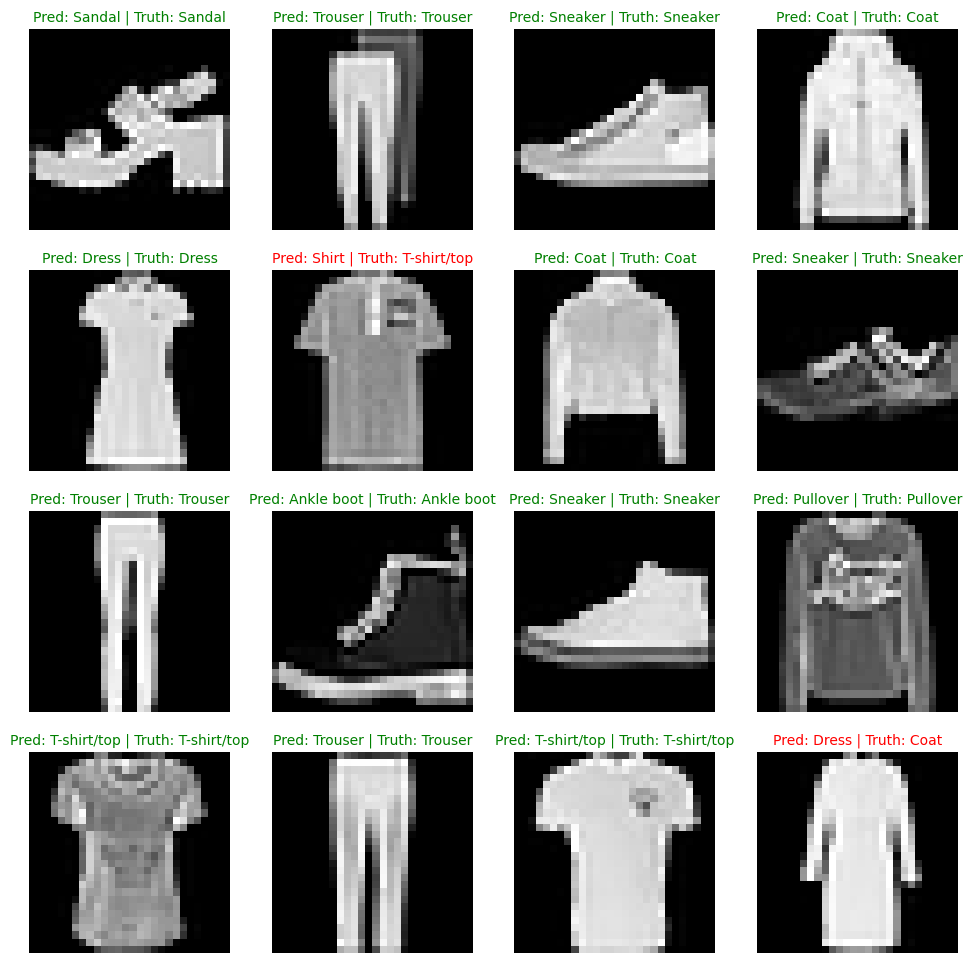

In [27]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
    # Create subplot
    plt.subplot(nrows, ncols, i+1)
    
    # Plot target image
    plt.imshow(sample.squeeze(), cmap="gray")
    
    # Find the prediction (in text form, e.g "Sandal")
    pred_label = class_names[pred_classes[i]]
    
    # Get truth label in text form
    truth_label = class_names[test_labels[i]]
    
    # Create a title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality between pred and truth and change color of title text
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
        
    plt.axis(False);

## 5. Plot confusion matrix to further evaluate model

In [30]:
# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        y_logits = model_0(X)
        
        # Turn predictions from logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        
        # Put prediction on CPU for evaluation
        y_preds.append(y_pred.cpu())
        
# Concatenate list of predictions into a tensor
# print(y_preds)
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

In [31]:
len(y_pred_tensor)

10000

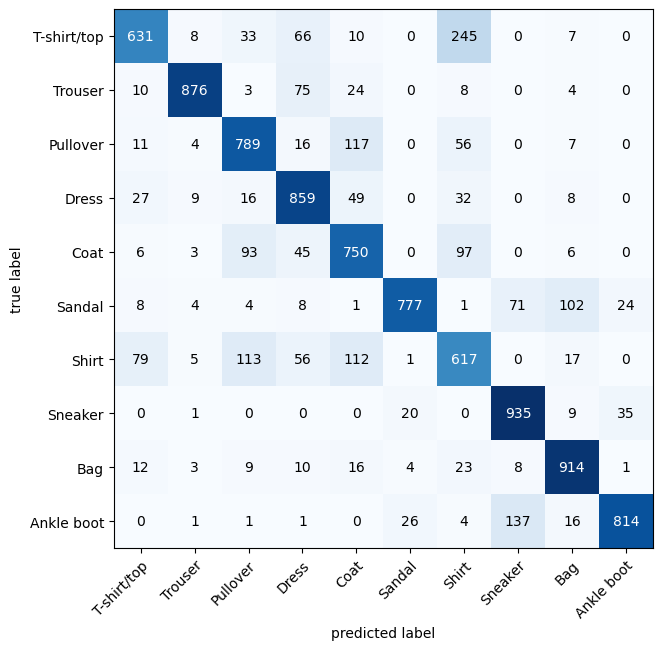

In [32]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 6. Save and load model

In [33]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "tinyvgg.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\tinyvgg.pth


In [34]:
# Create a new instance of TinyVGG (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_0 = TinyVGG(input_shape=1, 
                         hidden_units=10, # try changing this to 128 and seeing what happens 
                         output_shape=10) 

# Load in the saved state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_0 = loaded_model_0.to(device)

In [35]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_0_results = eval_model(
    model=loaded_model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'TinyVGG',
 'model_loss': 0.30807551741600037,
 'model_acc': 89.34704472843451}

In [36]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_0_results["model_loss"]), 
              torch.tensor(loaded_model_0_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)

## Closing Notes

This is to show the results of the TinyVGG model and see the results against the FashionMNIST dataset.

Have fun with the notebook and maybe carry out some more experiments on to it yourself to see if you can improve the performance even further. 